In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
rules = pd.read_csv("recommend-output.csv")

to_lib2cnt = {to_lib: len(rows) for to_lib, rows in rules.groupby(by="toLib")}
from_lib2cnt = {from_lib: len(rows) for from_lib, rows in rules.groupby(by="fromLib")}
rules["confTeyton"] = (rules["ruleCountSameCommit"] / np.maximum(
    rules["toLib"].apply(lambda x: to_lib2cnt[x]),
    rules["fromLib"].apply(lambda x: from_lib2cnt[x])
)).fillna(0)

ground_truth = pd.read_excel("manual/ground-truth.xlsx")
confirmed_rule_set = set(zip(
    ground_truth[ground_truth["isConfirmed"]]["fromLib"], 
    ground_truth[ground_truth["isConfirmed"]]["toLib"]
))
possible_rule_set = set(zip(
    ground_truth[ground_truth["ruleCount"] > 0]["fromLib"], 
    ground_truth[ground_truth["ruleCount"] > 0]["toLib"]
))
possible_rules = rules[rules["isPossible"]]
confirmed_rules = rules[rules["isConfirmed"]]
other_rules = rules[~rules["isConfirmed"] & ~rules["isPossible"]]
print("# rules = {}, # confirmed = {}, # possible = {}, # other = {}".format(
    len(rules), len(confirmed_rules), len(possible_rules), len(other_rules)))

# rules = 243152, # confirmed = 773, # possible = 1446, # other = 241706


In [3]:
rules

,fromLib,toLib,isConfirmed,confidence,confidence2,confTeyton,ruleCountSameCommit,ruleCount,ruleFreqSameCommit,ruleFreq,...,concurrenceAdjustment,positionSupport,commitDistance,methodChangeCount,apiSupport,possibleCommitCount,commitMessageSupport,ruleFreqToLibSameCommit,similarity,isPossible
0,antlr:antlr,org.antlr:antlr-runtime,True,0.089223,1.757816e-02,0.10,2,4,0.10,0.200000,...,0.076923,0.677741,0.562934,162,1.0,2,1.584963,1.000000,0.696568,True
1,antlr:antlr,com.googlecode.json-simple:json-simple,False,0.010632,1.948333e-03,0.10,2,3,0.10,0.150000,...,0.083333,0.738095,0.670782,0,0.0,2,1.584963,0.583333,0.357956,False
2,antlr:antlr,javax.xml.bind:jaxb-api,False,0.006672,1.219109e-03,0.10,2,3,0.10,0.150000,...,0.033333,0.133764,0.667200,0,0.0,1,1.000000,0.300000,0.000000,False
3,antlr:antlr,org.jboss.shrinkwrap.resolver:shrinkwrap-resol...,False,0.005015,1.972946e-03,0.10,2,4,0.10,0.200000,...,0.153846,0.499223,0.501500,0,0.0,1,1.000000,0.466667,0.131488,False
4,antlr:antlr,org.infinispan:infinispan-atomic-factory,False,0.005000,5.000000e-03,0.05,1,1,0.05,0.050000,...,1.000000,0.857143,1.000000,0,0.0,1,1.000000,0.150000,0.000000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243147,xstream:xstream,jline:jline,False,0.000000,1.485762e-11,0.00,0,1,0.00,0.029412,...,0.200000,0.029703,0.000106,0,0.0,0,0.000000,0.000000,0.236324,False
243148,xstream:xstream,tomcat:jasper-compiler-jdt,False,0.000000,1.451526e-11,0.00,0,1,0.00,0.029412,...,0.125000,0.031746,0.000118,0,0.0,0,0.000000,NaN,0.000000,False
243149,xstream:xstream,tomcat:jasper-runtime,False,0.000000,1.390094e-11,0.00,0,1,0.00,0.029412,...,0.125000,0.031088,0.000116,0,0.0,0,0.000000,NaN,0.000000,False
243150,xstream:xstream,jetty:org.mortbay.jetty,False,0.000000,1.390094e-11,0.00,0,1,0.00,0.029412,...,0.125000,0.031414,0.000116,0,0.0,0,0.000000,NaN,0.000000,False


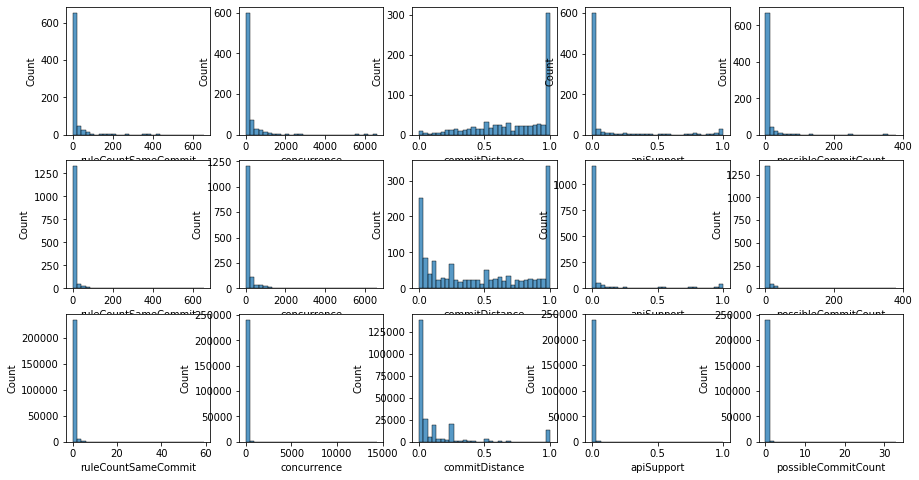

In [4]:
data = [rules[rules["isConfirmed"]], rules[rules["isPossible"]], rules[(~rules["isPossible"]) & (~rules["isConfirmed"])]]
axis = [
    "ruleCountSameCommit", # "ruleFreq", 
    "concurrence", "commitDistance", "apiSupport", "possibleCommitCount", 
    # "similarity"
]
fig, axes = plt.subplots(3, len(axis), figsize=(3 * len(axis), 8))
for i in range(0, 3):
    for j in range(0, len(axis)):
        sns.histplot(data=data[i], x=axis[j], ax=axes[i][j], bins=30)
fig.show()

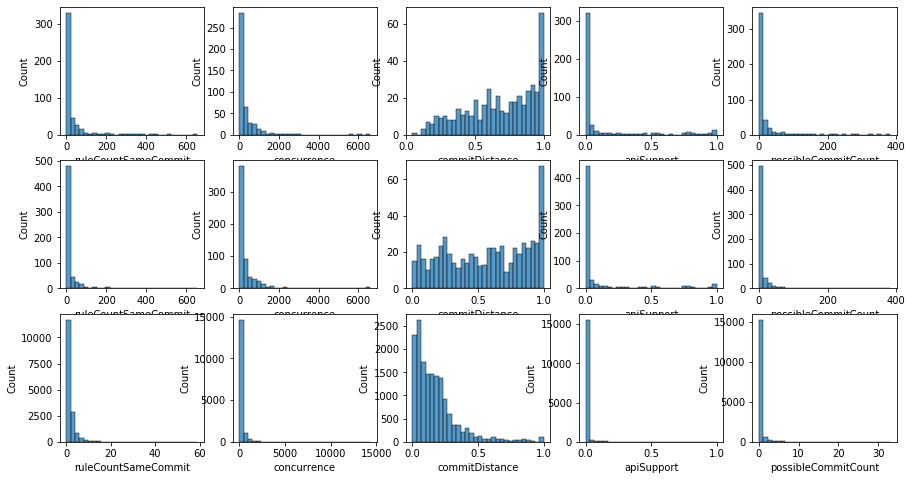

In [5]:
filtered_rules = rules[(rules["ruleCount"] >= 5) & (rules["concurrence"] >= 10)]
filtered_possible_rules = filtered_rules[filtered_rules["isPossible"]]
filtered_confirmed_rules = filtered_rules[filtered_rules["isConfirmed"]]
data = [
    filtered_rules[filtered_rules["isConfirmed"]], 
    filtered_rules[filtered_rules["isPossible"]], 
    filtered_rules[(~filtered_rules["isPossible"]) & (~filtered_rules["isConfirmed"])]
]
fig, axes = plt.subplots(3, len(axis), figsize=(3 * len(axis), 8))
for i in range(0, 3):
    for j in range(0, len(axis)):
        sns.histplot(data=data[i], x=axis[j], ax=axes[i][j], bins=30)
fig.show()

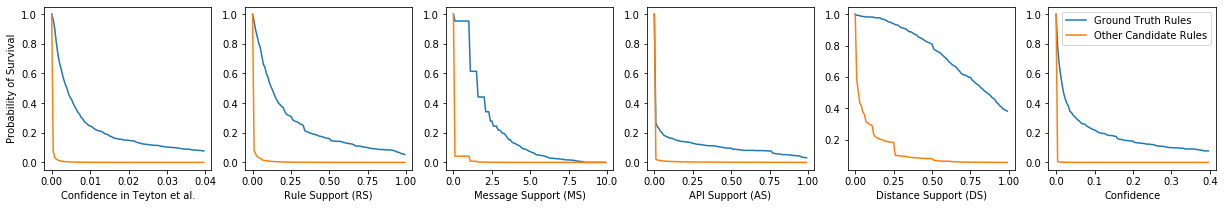

In [4]:
def get_dist(rules, possible_rules, confirmed_rules, metric, min_val, max_val, interval):
    possible_vals = []
    confirmed_vals = []
    other_vals = []
    for i in np.arange(min_val, max_val, interval):
        possible_vals.append(len(possible_rules[possible_rules[metric] >= i]) / len(possible_rules))
        confirmed_vals.append(len(confirmed_rules[confirmed_rules[metric] >= i]) / len(confirmed_rules))
        other_vals.append(len(other_rules[other_rules[metric] >= i]) / len(other_rules))
    return possible_vals, confirmed_vals, other_vals
params = [
    # ("ruleCountSameCommit", 0, 600, 6),
    # ("ruleFreqToLibSameCommit", 0, 1, 0.01),
    # ("ruleCount", 0, 600, 6), 
    ("confTeyton", 0, 0.04, 0.0004, "Confidence in Teyton et al."),
    ("ruleFreqSameCommit", 0, 1, 0.01, "Rule Support (RS)"),
    # ("possibleCommitCount", 0, 100, 1),
    ("commitMessageSupport", 0, 10, 0.1, "Message Support (MS)"),
    # ("ruleFreq", 0, 1, 0.01), 
    # ("concurrence", 0, 1000, 10), 
    # ("popularityRegularization", 0, 1, 0.01),
    # ("positionSupport", 0, 1, 0.01), 
    ("apiSupport", 0, 1, 0.01, "API Support (AS)"),
    ("commitDistance", 0, 1, 0.01, "Distance Support (DS)"),
    # ("methodChangeCount", 0, 100, 1),
    # ("similarity", 0, 1, 0.01),
    ("confidence", 0, 0.4, 0.004, "Confidence"),
]
fig, axes = plt.subplots(1, len(params), figsize=(3.5 * len(params), 3))
for i, param in enumerate(params):
    possible, confirmed, other = get_dist(rules, possible_rules, confirmed_rules, *(param[0:4]))
    x = list(np.arange(param[1], param[2], param[3]))
    axes[i].plot(x, confirmed, label="Ground Truth Rules")
    # axes[i].plot(x, possible, label="Possible")
    axes[i].plot(x, other, label="Other Candidate Rules")
    if len(param) == 4:
        axes[i].set_xlabel(param[0])
    elif len(param) == 5:
        axes[i].set_xlabel(param[4])
    if i == 0:
        axes[i].set_ylabel("Probability of Survival")
    if i == len(params) - 1:
        axes[i].legend()
fig.show()
fig.savefig("pic/dist.pdf", bbox_inches="tight")
fig.savefig("pic/dist.png", bbox_inches="tight", dpi=300, transparent=True)

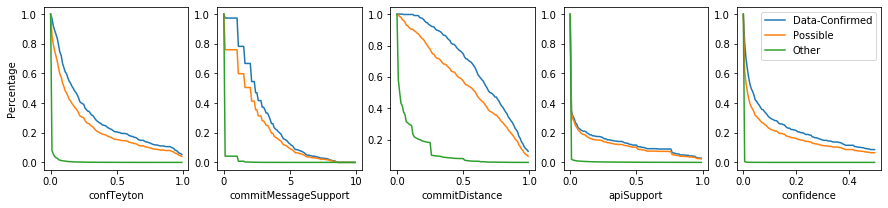

In [7]:
fig, axes = plt.subplots(1, len(params), figsize=(3 * len(params), 3))
for i, param in enumerate(params):
    possible, confirmed, other = get_dist(filtered_rules, filtered_possible_rules, filtered_confirmed_rules, *param)
    x = list(np.arange(param[1], param[2], param[3]))
    axes[i].plot(x, confirmed, label="Data-Confirmed")
    axes[i].plot(x, possible, label="Possible")
    axes[i].plot(x, other, label="Other")
    axes[i].set_xlabel(param[0])
    if i == 0:
        axes[i].set_ylabel("Percentage")
    if i == len(params) - 1:
        axes[i].legend()
fig.show()

In [8]:
def show_dist2(filter_func):
    print("# possible = {}({:.2%}), # confirmed = {}({:.2%}), # other = {}({:.2%})".format(
            len(filter_func(possible_rules)),
            len(filter_func(possible_rules)) / len(possible_rules),
            len(filter_func(confirmed_rules)),
            len(filter_func(confirmed_rules)) / len(confirmed_rules),
            len(filter_func(other_rules)),
            len(filter_func(other_rules)) / len(other_rules),
    ))
show_dist2(lambda rules: rules[(rules["ruleCount"] >= 5) & (rules["concurrence"] >= 10)])
show_dist2(lambda rules: rules[(rules["ruleCount"] >= 2) & (rules["concurrence"] >= 15) & (rules["positionSupport"] >= 0.4)])

# possible = 600(41.49%), # confirmed = 451(58.34%), # other = 16235(6.72%)
# possible = 716(49.52%), # confirmed = 486(62.87%), # other = 20611(8.53%)


In [9]:
def show_dist(metric, min_val, max_val, interval):
    possible_rules = rules[rules["isPossible"]]
    confirmed_rules = rules[rules["isConfirmed"]]
    other_rules = rules[~rules["isConfirmed"] & ~rules["isPossible"]]
    print("Distribution of {}:".format(metric))
    for i in np.arange(min_val, max_val, interval):
        print("{} >= {:.2f}: # possible = {}({:.2%}), # confirmed = {}({:.2%}), # other = {}({:.2%})".format(
            metric, i,
            len(possible_rules[possible_rules[metric] >= i]),
            len(possible_rules[possible_rules[metric] >= i]) / len(possible_rules),
            len(confirmed_rules[confirmed_rules[metric] >= i]),
            len(confirmed_rules[confirmed_rules[metric] >= i]) / len(confirmed_rules),
            len(other_rules[other_rules[metric] >= i]),
            len(other_rules[other_rules[metric] >= i]) / len(other_rules),
        ))
    print("")
params = [
    ("ruleCountSameCommit", 0, 30, 1), 
    ("ruleFreqSameCommit", 0, 1, 0.02), 
    ("ruleCount", 0, 30, 1), 
    ("ruleFreq", 0, 1, 0.02), 
    ("concurrence", 0, 30, 1), 
    ("concurrenceAdjustment", 0, 1, 0.02),
    ("positionSupport", 0, 1, 0.02), 
    ("apiSupport", 0, 1, 0.02),
    ("possibleCommitCount", 0, 30, 1)
]
for param in params:
    show_dist(*param)

Distribution of ruleCountSameCommit:
ruleCountSameCommit >= 0.00: # possible = 1446(100.00%), # confirmed = 773(100.00%), # other = 241706(100.00%)
ruleCountSameCommit >= 1.00: # possible = 946(65.42%), # confirmed = 756(97.80%), # other = 29811(12.33%)
ruleCountSameCommit >= 2.00: # possible = 671(46.40%), # confirmed = 597(77.23%), # other = 7332(3.03%)
ruleCountSameCommit >= 3.00: # possible = 526(36.38%), # confirmed = 489(63.26%), # other = 3092(1.28%)
ruleCountSameCommit >= 4.00: # possible = 436(30.15%), # confirmed = 409(52.91%), # other = 1778(0.74%)
ruleCountSameCommit >= 5.00: # possible = 359(24.83%), # confirmed = 345(44.63%), # other = 1188(0.49%)
ruleCountSameCommit >= 6.00: # possible = 325(22.48%), # confirmed = 314(40.62%), # other = 830(0.34%)
ruleCountSameCommit >= 7.00: # possible = 295(20.40%), # confirmed = 289(37.39%), # other = 595(0.25%)
ruleCountSameCommit >= 8.00: # possible = 274(18.95%), # confirmed = 271(35.06%), # other = 461(0.19%)
ruleCountSameCommit >